# Imports

In [1]:
import rasterio
import json
from shapely.geometry import shape
from rasterio.features import rasterize
from skimage import morphology

from glob import glob
from os import path

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib notebook

# Helper Functions

#### a custom colormap, transparent at low values and red at high values

In [2]:
cmap = plt.cm.Reds
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:, -1] = np.zeros_like(my_cmap[:, -1])
my_cmap[-1:, -1] = 0.6
my_cmap = ListedColormap(my_cmap)

#### open corresponding tif/json, given path to any tif/json

In [2]:
def get_tif(json_file_name, tif_dir):
    tif_basename = path.basename(json_file_name).replace('spacenetroads', 'RGB-PanSharpen').replace('.geojson', '.tif')
    return rasterio.open(path.join(tif_dir, tif_basename))

def get_json(tif_file_name, json_dir):
    json_basename = path.basename(tif_file_name).replace('RGB-PanSharpen', 'spacenetroads').replace('.tif', '.geojson')
    return json.load(open(path.join(json_dir, json_basename), 'r'))

# Load Data

In [2]:
datadir = '../../data/'
json_dir = path.join(datadir, 'geojson', 'spacenetroads')
tif_dir = path.join(datadir, 'RGB-PanSharpen')

json_files = glob('{}/*.geojson'.format(json_dir))
tif_files = glob('{}/*.tif'.format(tif_dir))

In [7]:
tif = rasterio.open(tif_files[0])
js = get_json(tif_files[0], json_dir)

In [8]:
img_data = np.rollaxis(tif.read(), 0, 3) / 2048.

In [9]:
road_raster = rasterize(
    [(feature['geometry'], 1) for feature in js['features']],
    out_shape=tif.shape, transform=tif.transform, all_touched=True
)

# Dilate the road raster

In [10]:
kernel = morphology.disk(10)

dilated_road_raster = morphology.binary_dilation(road_raster, selem=kernel).astype(int)

# Have a look

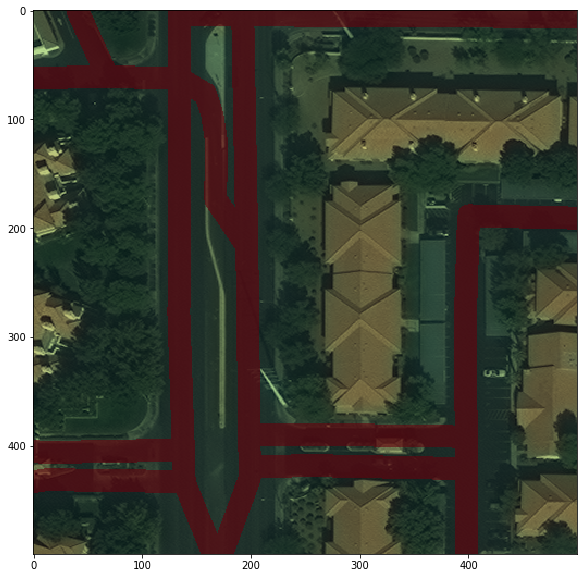

In [11]:
size = 500  # if very large, shows entire image

plt.figure(figsize=(10, 10))
plt.imshow(img_data[:size, :size])
plt.imshow(dilated_road_raster[:size, :size], vmin=0, vmax=1, cmap=my_cmap)

------------------------------------------------------------------

# Explore Data Generator's output

In [12]:
from data_generator import SpacenetGenerator

Using TensorFlow backend.


In [13]:
traingen = SpacenetGenerator('../../data/').random_generator(batch_size=5)
img, lab = next(traingen)

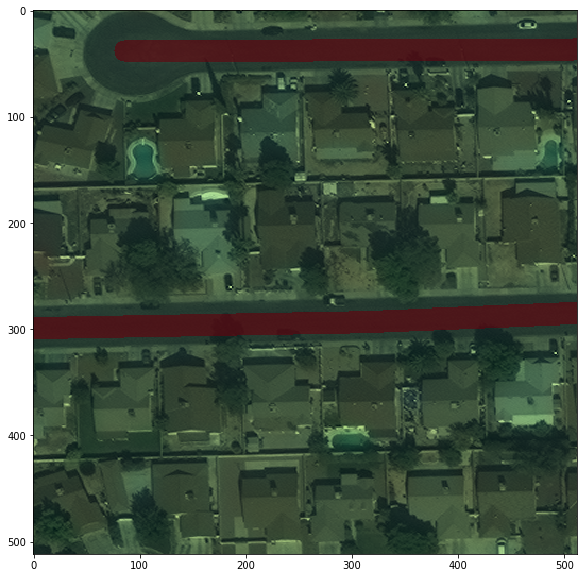

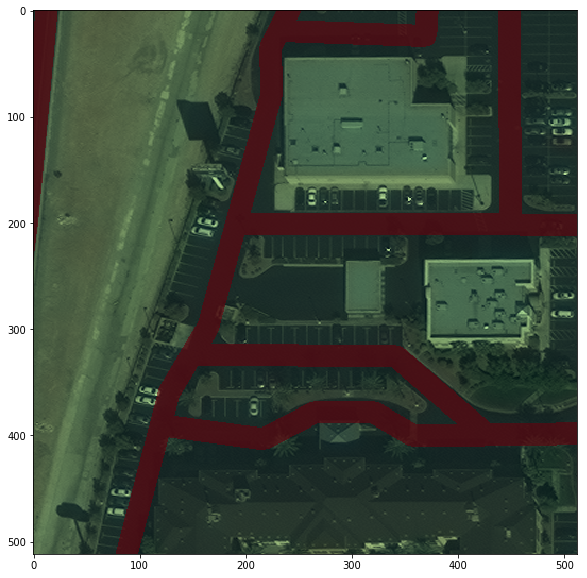

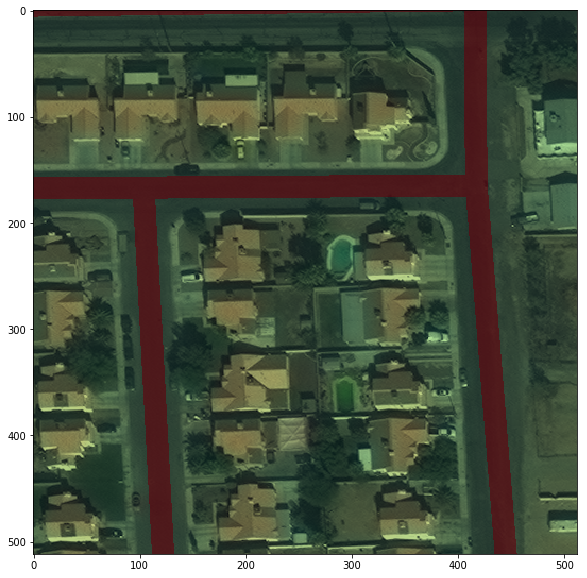

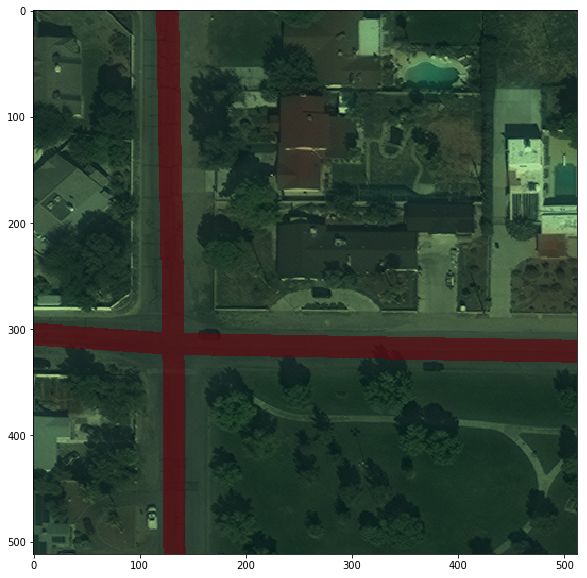

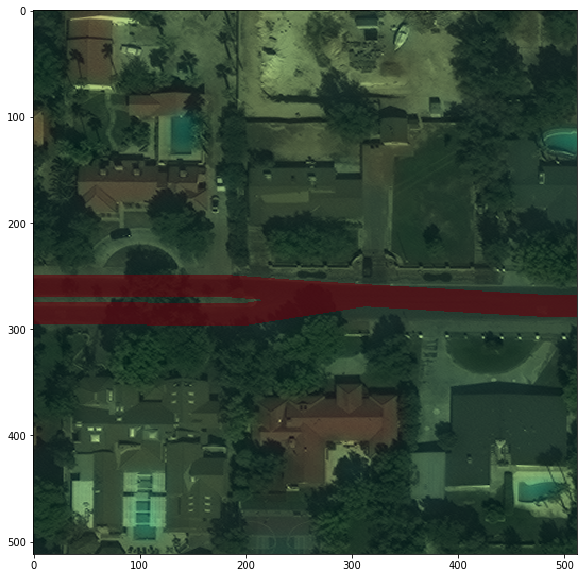

In [25]:
for i in range(len(img)):
    this_img = img[i]
    this_label = np.argmax(lab[i], axis=-1)
    this_label = this_label.reshape(this_img.shape[0], this_img.shape[1])
    
    plt.figure(figsize=(10, 10))
    plt.imshow(this_img)
    plt.imshow(this_label, vmin=0, vmax=1, cmap=my_cmap)

------------------------------------------------------------------------------

# Split into train / validation data sets

Move data from `datadir` into `datadir/train` or `datadir/val`.
Only run once; you will need to put all files back into `datadir` to re-run.

In [3]:
from subprocess import run

In [2]:
datadir = '../../data/'
json_dir = path.join(datadir, 'geojson', 'spacenetroads')
tif_dir = path.join(datadir, 'RGB-PanSharpen')

json_files = glob('{}/*.geojson'.format(json_dir))
tif_files = glob('{}/*.tif'.format(tif_dir))

In [4]:
run('mkdir -p {}'.format(
    path.join(datadir, 'train', 'geojson', 'spacenetroads')
    ), shell=True)
run('mkdir -p {}'.format(
    path.join(datadir, 'val', 'geojson', 'spacenetroads')
    ), shell=True)

run('mkdir -p {}'.format(
    path.join(datadir, 'train', 'RGB-PanSharpen')
    ), shell=True)
run('mkdir -p {}'.format(
    path.join(datadir, 'val', 'RGB-PanSharpen')
    ), shell=True)

CompletedProcess(args='mkdir -p ../../data/val/RGB-PanSharpen', returncode=0)

In [5]:
p_validation = 0.1

validation_files = np.random.choice(json_files,
                                    size=int(p_validation * len(json_files)))

In [12]:
def move_file(json_file, out_json_path, out_tif_path):
    new_path = path.join(out_json_path, path.basename(json_file))
    cmd1 = 'mv {} {}'.format(json_file, new_path)
    tif_basename = path.basename(json_file).replace('spacenetroads', 'RGB-PanSharpen').replace('.geojson', '.tif')
    tif_file = path.join(datadir, 'RGB-PanSharpen', tif_basename)
    new_path = path.join(out_tif_path, path.basename(tif_basename))
    cmd2 = 'mv {} {}'.format(tif_file, new_path)
    run(cmd1, shell=True)
    run(cmd2, shell=True)

# move subset of files into val directory
val_json_path = path.join(datadir, 'val', 'geojson', 'spacenetroads')
val_tif_path = path.join(datadir, 'val', 'RGB-PanSharpen')
for i, json_file in enumerate(validation_files):
    move_file(json_file, val_json_path, val_tif_path)
print('moved {} files to validation directory'.format(i))

# and move the remainder into train
train_json_path = path.join(datadir, 'train', 'geojson', 'spacenetroads')
train_tif_path = path.join(datadir, 'train', 'RGB-PanSharpen')
for i, json_file in enumerate(glob(path.join(datadir, 'geojson', 'spacenetroads', '*.geojson'))):
    move_file(json_file, train_json_path, train_tif_path)
print('moved {} files to train directory'.format(i))

moved 97 files to validation directory
moved 892 files to train directory
